In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# small numeric cleaning helper (adapted from earlier)
def to_numeric_safe(series):
    s = series.astype(str).str.strip()
    s = s.replace(['nan','NaN','None','NONE','none',''], np.nan)
    s = s.str.replace(".", "", regex=False)   # remove thousand separators like 1.234.000
    s = s.str.replace(",", ".", regex=False)  # comma decimal -> dot
    s = s.str.replace(" ", "", regex=False)
    return pd.to_numeric(s, errors='coerce')

In [4]:
df = pd.read_parquet("../data/processed/insurance_data.parquet")
print("rows, cols:", df.shape)
print("Sample columns:", df.columns[:30].tolist())

# detect claim column
claim_cols = [c for c in df.columns if 'claim' in c.lower()]
print("Claim-like columns detected:", claim_cols)

# prefer TotalClaims if present
if 'TotalClaims' in df.columns:
    claim_col = 'TotalClaims'
elif claim_cols:
    claim_col = claim_cols[0]
    print(f"Using detected claim column: {claim_col}")
else:
    raise RuntimeError("No claim column found. Please add TotalClaims or a claim-like column to dataset.")


rows, cols: (1000098, 52)
Sample columns: ['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth', 'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language', 'Bank', 'AccountType', 'MaritalStatus', 'Gender', 'Country', 'Province', 'PostalCode', 'MainCrestaZone', 'SubCrestaZone', 'ItemType', 'mmcode', 'VehicleType', 'RegistrationYear', 'make', 'Model', 'Cylinders', 'cubiccapacity', 'kilowatts', 'bodytype', 'NumberOfDoors', 'VehicleIntroDate', 'CustomValueEstimate']
Claim-like columns detected: ['TotalClaims']


In [5]:
# cell 3
# ensure TotalPremium and claim_col numeric
df['TotalPremium'] = to_numeric_safe(df['TotalPremium'])
df[claim_col] = to_numeric_safe(df[claim_col])

# create HasClaim boolean and ClaimSeverity (only where claim > 0)
df['HasClaim'] = df[claim_col].fillna(0) > 0
df['ClaimSeverity'] = df.loc[df['HasClaim'], claim_col]  # NaN where no claim

# margin
df['Margin'] = df['TotalPremium'] - df[claim_col].fillna(0)

# quick checks
print(df[['TotalPremium', claim_col, 'HasClaim', 'ClaimSeverity', 'Margin']].describe(include='all').T)


                   count unique    top    freq                   mean  \
TotalPremium   1000098.0    NaN    NaN     NaN  54307375839965.539062   
TotalClaims    1000098.0    NaN    NaN     NaN   8826905653592.328125   
HasClaim         1000098      2  False  997310                    NaN   
ClaimSeverity     2788.0    NaN    NaN     NaN     3170670735229610.5   
Margin         1000098.0    NaN    NaN     NaN   45480470186373.21875   

                                std                  min                 25%  \
TotalPremium   143237961406110.0625   -782576754385965.0                 0.0   
TotalClaims       493899241013017.0 -12002412280701796.0                 0.0   
HasClaim                        NaN                  NaN                 NaN   
ClaimSeverity    8800825885042490.0               2500.0  116646165350877.25   
Margin          507073950282378.625 -65015022807017528.0                 0.0   

                             50%                 75%                  max  
Tota

In [6]:
# cell 4
def test_claim_frequency_by_group(group_col, df=df, alpha=0.05):
    """
    Chi-square test across groups for claim frequency.
    Returns: chi2, p, df, table
    """
    ct = pd.crosstab(df[group_col], df['HasClaim'])
    chi2, p, dof, expected = stats.chi2_contingency(ct)
    return dict(chi2=chi2, p=p, dof=dof, table=ct, expected=expected)

def test_claim_severity_by_group(group_col, df=df, alpha=0.05):
    """
    Non-parametric test for differences in severity across groups:
    Kruskal-Wallis test if >2 groups, Mann-Whitney U for 2 groups.
    Returns test stats and p-value. Uses ClaimSeverity (dropna).
    """
    groups = []
    names = []
    for name, g in df.groupby(group_col):
        arr = g.loc[g['HasClaim'], 'ClaimSeverity'].dropna()
        if len(arr) > 0:
            groups.append(arr)
            names.append(name)
    if len(groups) < 2:
        return dict(error="Not enough groups with claims")
    if len(groups) == 2:
        stat, p = stats.mannwhitneyu(groups[0], groups[1], alternative='two-sided')
        return dict(test='mannwhitneyu', stat=stat, p=p, groups=len(groups))
    else:
        stat, p = stats.kruskal(*groups)
        return dict(test='kruskal', stat=stat, p=p, groups=len(groups))
    
def test_margin_by_group(group_col, df=df, alpha=0.05):
    """
    Test difference in margin across groups. Use ANOVA if normal-ish and groups>2,
    else Kruskal-Wallis. We'll use Kruskal-Wallis to be robust.
    """
    groups = [g['Margin'].dropna() for _, g in df.groupby(group_col) if len(g)>10]
    if len(groups) < 2:
        return dict(error="Not enough groups")
    stat, p = stats.kruskal(*groups)
    return dict(test='kruskal', stat=stat, p=p, groups=len(groups))


In [7]:
# cell 5
alpha = 0.05

# H0: no risk differences across provinces (frequency & severity)
freq_prov = test_claim_frequency_by_group('Province')
sev_prov = test_claim_severity_by_group('Province')
margin_prov = test_margin_by_group('Province')

print("Province - claim frequency: p =", freq_prov['p'])
print("Province - claim severity: p =", sev_prov.get('p'))
print("Province - margin: p =", margin_prov.get('p'))

# H0: no risk differences between zip codes (we'll test top N zipcodes to keep power)
top_zips = df['PostalCode'].value_counts().head(20).index.tolist()
df_zips = df[df['PostalCode'].isin(top_zips)].copy()
freq_zip = test_claim_frequency_by_group('PostalCode', df=df_zips)
sev_zip = test_claim_severity_by_group('PostalCode', df=df_zips)
margin_zip = test_margin_by_group('PostalCode', df=df_zips)

print("Top ZIPs - frequency p =", freq_zip['p'])
print("Top ZIPs - severity p =", sev_zip.get('p'))
print("Top ZIPs - margin p =", margin_zip.get('p'))

# H0: no significant margin difference between zip codes -> above covers top zipcodes
# H0: no significant risk difference between Women and Men
if 'Gender' in df.columns:
    freq_gender = test_claim_frequency_by_group('Gender')
    sev_gender = test_claim_severity_by_group('Gender')
    margin_gender = test_margin_by_group('Gender')
    print("Gender - frequency p =", freq_gender['p'])
    print("Gender - severity p =", sev_gender.get('p'))
    print("Gender - margin p =", margin_gender.get('p'))
else:
    print("Gender column missing")


Province - claim frequency: p = 5.925510718204677e-19
Province - claim severity: p = 0.0534785707821884
Province - margin: p = 0.0
Top ZIPs - frequency p = 2.6030421728100892e-14
Top ZIPs - severity p = 4.6725458438774285e-05
Top ZIPs - margin p = 0.0
Gender - frequency p = 0.026570248768437145
Gender - severity p = 0.16857241188770714
Gender - margin p = 0.0


In [8]:
# cell 6
# Example: if severity across provinces is significant, perform Tukey on log-severity (or pairwise MWU)
if sev_prov.get('p') is not None and sev_prov['p'] < alpha:
    # prepare data for pairwise test using only provinces with claims
    severity_df = df[df['HasClaim']].loc[:, ['Province', 'ClaimSeverity']].dropna()
    # log-transform for normality if desired
    severity_df['log_sev'] = np.log1p(severity_df['ClaimSeverity'])
    res = pairwise_tukeyhsd(severity_df['log_sev'], severity_df['Province'])
    print(res.summary())


In [10]:
# cell 7
def interpret_test(name, res, alpha=0.05):
    p = res.get('p')
    if p is None:
        return f"{name}: test not executed or insufficient data."
    if p < alpha:
        return f"{name}: REJECT H0 (p={p:.4g}) — statistically significant difference."
    else:
        return f"{name}: FAIL TO REJECT H0 (p={p:.4g}) — no evidence of difference."

print(interpret_test("Province - frequency", freq_prov))
print(interpret_test("Province - severity", sev_prov))
print(interpret_test("TopZIPs - frequency", freq_zip))
print(interpret_test("Gender - frequency", freq_gender if 'freq_gender' in locals() else {}))


Province - frequency: REJECT H0 (p=5.926e-19) — statistically significant difference.
Province - severity: FAIL TO REJECT H0 (p=0.05348) — no evidence of difference.
TopZIPs - frequency: REJECT H0 (p=2.603e-14) — statistically significant difference.
Gender - frequency: REJECT H0 (p=0.02657) — statistically significant difference.


In [32]:
def plot_claim_frequency(df, group_col):
    freq = df.groupby(group_col)['HasClaim'].mean().sort_values()
    plt.figure(figsize=(12,5))
    freq.plot.bar()
    plt.title(f"Claim Frequency by {group_col}")
    plt.ylabel("Claim Frequency")
    plt.xlabel(group_col)
    plt.tight_layout()
    plt.show()

def plot_margin(df, group_col):
    # Clean missing
    df = df.dropna(subset=[group_col, "Margin"])
    
    # Clean negatives
    df = df[df["Margin"] >= 0]

    # Handle large cardinality columns
    if df[group_col].nunique() > 20:
        top_values = df[group_col].value_counts().head(20).index
        df = df[df[group_col].isin(top_values)]

    plt.figure(figsize=(14,5))
    sns.boxplot(data=df, x=group_col, y=np.log1p(df["Margin"]))
    plt.title(f"Log Margin by {group_col}")
    plt.xticks(rotation=45)
    plt.show()



df.describe(percentiles=[.01, .05, .95, .99])
df[df["TotalPremium"] > 1e7].head()
df[df["TotalClaims"] > 1e7].head()

df["TotalClaims"] = df["TotalClaims"].clip(lower=0, upper=1e6)
df["TotalPremium"] = df["TotalPremium"].clip(lower=0, upper=5e5)


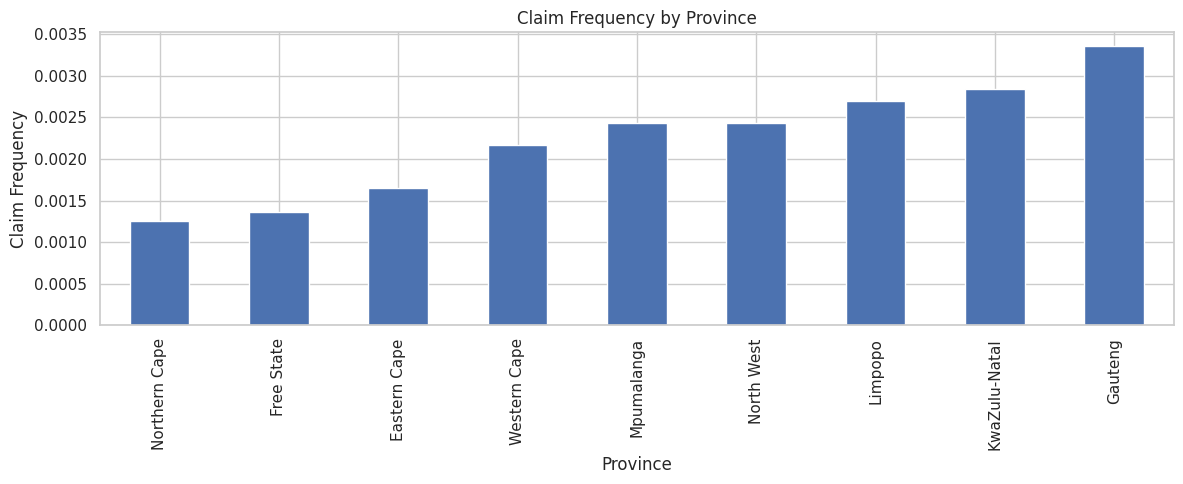

In [24]:
plot_claim_frequency(df, "Province")

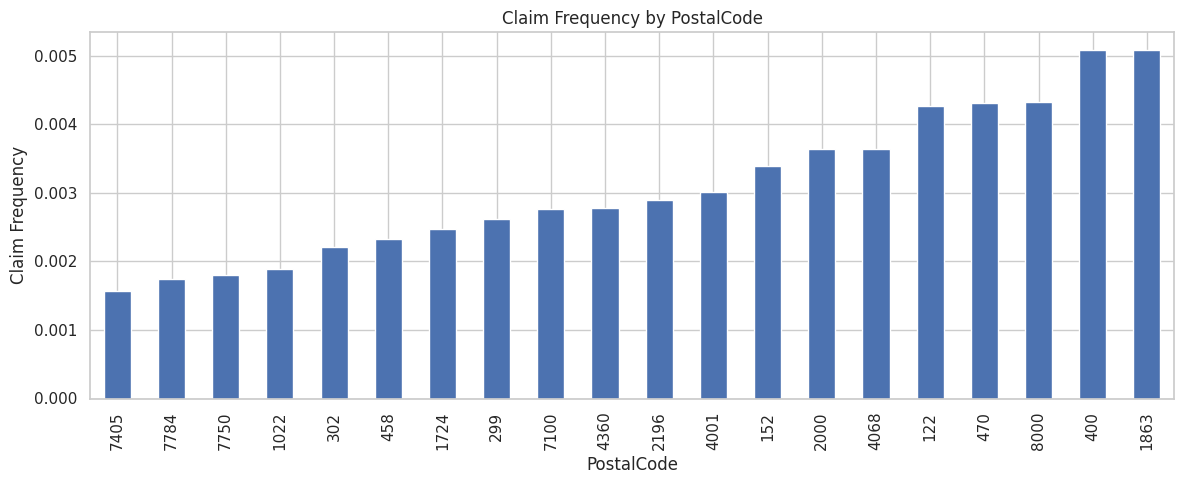

In [25]:
plot_claim_frequency(df_zips, "PostalCode")

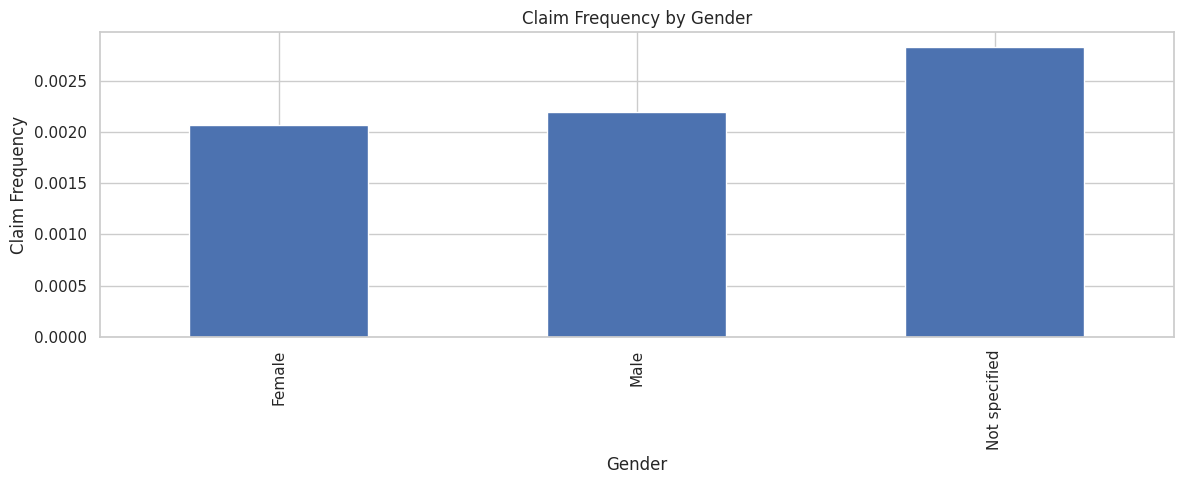

In [26]:
plot_claim_frequency(df, "Gender")

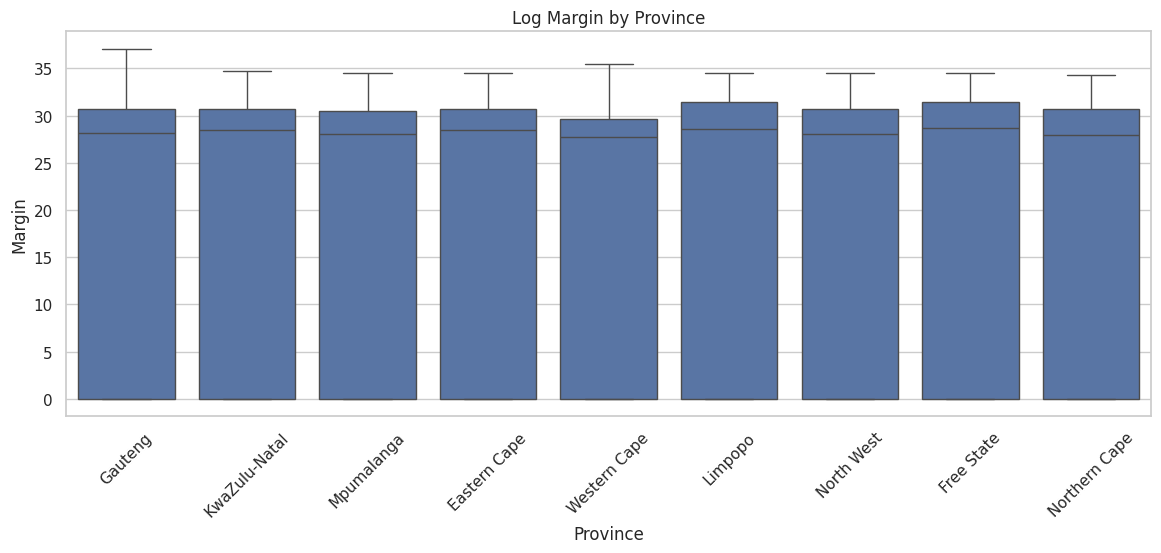

In [33]:
plot_margin(df, "Province")

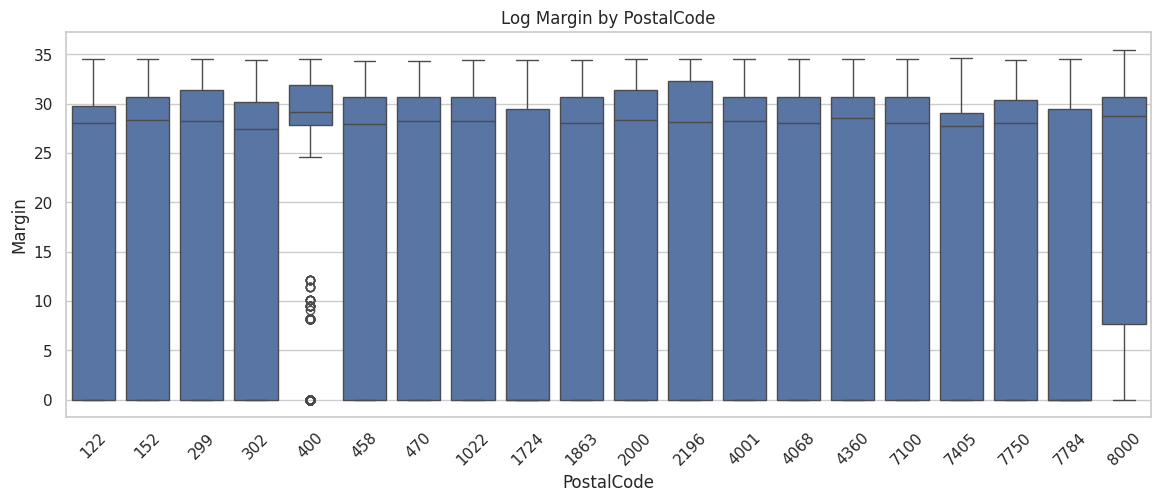

In [34]:
plot_margin(df_zips, "PostalCode")

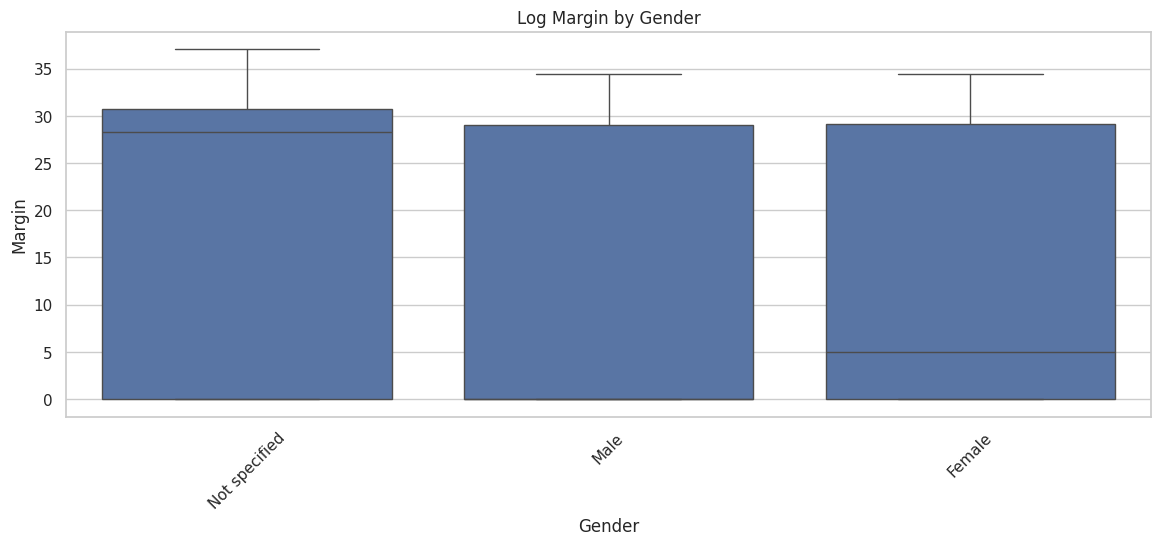

In [35]:
plot_margin(df, "Gender")

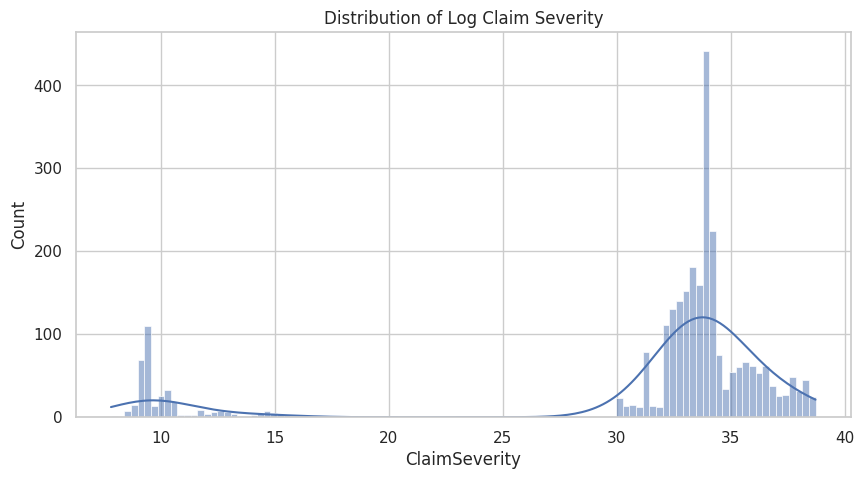

In [30]:
severity = df.loc[df['HasClaim'], 'ClaimSeverity'].dropna()

plt.figure(figsize=(10,5))
sns.histplot(np.log1p(severity), kde=True)
plt.title("Distribution of Log Claim Severity")
plt.show()

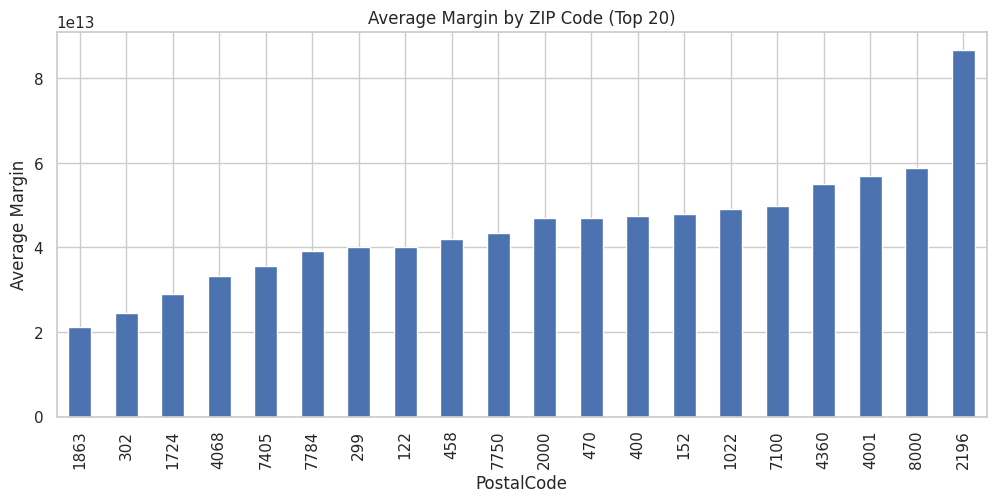

In [31]:
margin_zip = df_zips.groupby("PostalCode")["Margin"].mean().sort_values()

plt.figure(figsize=(12,5))
margin_zip.plot.bar()
plt.title("Average Margin by ZIP Code (Top 20)")
plt.ylabel("Average Margin")
plt.show()